# Diagnosis of Heart Disease in Patients

### Introduction:

Cardiovascular diseases are the world's leading cause of death, killing over 17.9 million people each year. A number of factors are known to contribute to heart diseases, including an individual’s cholesterol levels, blood pressure, and many others. According to the  world health organisation, identifying those at highest risk of cardiovascular diseases and ensuring they receive treatement can help prevent premature deaths. This is why it is so important that the main indicators of heart disease be identified, to detect the presence of any sort of heart disease early on so that proper tests can be done to ensure the health of patients. 

With this in mind, we will answer the following question in this report. Based on a patient’s cholesterol level and maximum measured heart rate, do they have heart disease? To regard the posed question, the processed Cleveland, Hungarian, Swiss, and Long Beach Heart Disease data sets will be used from the UCI Machine Learning Repository. The data sets from all of these locations will be used because they contain the same variables and give us more observations to use when making our predictive model. 

This dataset contains 14 variables relating to heart disease that were measured by doctors. There are 860  observations (rows) in the dataset that will be used for analysis. The 14 variables in the datasets are age, sex, cp (chest pain type), trestbps (resting blood pressure), chol (cholesterol), fbs (fasting blood sugar), restecg (resting electrocardiograph results), thalach (maximum heart rate achieved), exang (excersize induced angina), oldpeak (ST depression induced by exercise relative to rest), slope (the slope of the peak exercise ST segment), ca (number of major vessels (0-3) colored by flourosopy), thal (information not provided), num (presence of heart disease from 0 - 4). In our initial proposal, the chosen predictor variables were age, trestbps, and cholesterol which were used to predict the num variable from the Clevaland Patients data set. With num having five categories and the Clevaland data set having only 303 observations, the accuracy of our best model was very low, hovering at around 60 percent no matter which predictors we chose to use. Since this is only 6 percent better than a majority classifier, improvements needed to be made. 

After observing the other datasets, we identified that the thalach (maximum heart rate at checkup) variable contained good numeric data without too many values missing, and decided to add it to our model to see if it improved in accuracy. All of the other variables in the dataset were categorical and thus we decided they would not be very helpful in distinguishing between our 5 categories. Additionally we decided to change the number of categories we were predicting from 5 categories to 2, those being 0 for no presence of heart disease and 1 indicating the presence of any form of heart disease. This also helped clarify some ambiguity because the dataset did not contain a description of what each disease presence meant. After making these changes, we  found that while using all four predictors (age, resting blood pressure, cholesterol, and maximum heart rate) on our larger data set, the accuracy on the test data was around 68 percent. Removing age and resting blood pressure from our model using backward selection, we found that our testing accuracy increased when fitting our model with the new best k value, indicating that the choice of cholesterol and maximum heart rate had the strongest influence on our predicted variable. 

Using a classification method, these columns were used to help categorize individuals' heart conditions. We used the K-nearest neighbours classification algorithm to make our predictions after scaling our data in a recipe so each variable was weighted equally. After splitting our data into test and training data, we made a recipe, classification model, and workflow using cross-validation and tuning to get a better idea of the true accuracy of our model and choose the k-value to maximize this accuracy. 

## Methods and Results

### Exploratory Data Analysis

#### Importing Libraries

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# set seed for randomization
set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Reading Data from the web 

In [2]:
# URLs for all proccessed heart data in the archive
cleveland_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
hungary_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
switzerland_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
va_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"

# get each comma seperated datafram into R
cleveland_data <- read_delim(cleveland_url, col_names=FALSE, delim=",") 
hungary_data <- read_delim(hungary_url, col_names=FALSE, delim=",")
switzerland_data <- read_delim(switzerland_url, col_names=FALSE, delim=",")
va_data <- read_delim(va_url, col_names=FALSE, delim=",") 

# bind dataframes together to make full dataframe for analysis
heart_data <- rbind(cleveland_data, hungary_data, switzerland_data, va_data) %>% 
    # Select predictor and target variable column numbers from the description of the dataset at https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    # here we select cholesterol, max heart rate because they are the predictors that led to the highest accuracy in our knn model.
    # we also select disease because it is our predicted variable
    select(X4, X8, X14) %>%
    # remove rows with missing values, denoted by question marks in the dataset
    filter(X4 != "?", X8 != "?", X14 != "?") %>% 
    # much of the data had 0 as the cholesterol and max heart rate values, so we remove these rows since this is not possible and is thus invalid data.
    filter(X4 > 0, X8 > 0) %>% 
    # Convert all disease presences greater than 0 to be 1, indicating the patient has some form of heart disease
    mutate(X14 = case_when(X14 > 0 ~ 1, X14 == 0 ~ 0)) %>% 
    # Make target variable a factor
    mutate(X14 = as_factor(X14)) %>%
    # predictor variables were parsed by R as character columns so we convert them to numeric types
    mutate(X4 = as.numeric(X4), X8 = as.numeric(X8))

# Add column names to the dataframe
colnames(heart_data) <- c("cholesterol", "max_hr", "disease_presence")
# Split data into training and test set with 75% of data going to the training set
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease_presence) 
heart_train <- training(heart_split) 
heart_test <- testing(heart_split)

heart_train

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_char

cholesterol,max_hr,disease_presence
<dbl>,<dbl>,<fct>
145,150,0
160,108,1
120,129,1
⋮,⋮,⋮
127,154,1
122,100,1
120,93,1


#### Summary table of the number of observations in each class.

From the table we see that about 46 percent of the data has class 0 and 54 percent of the data has class 1 which is a fairly good balance. (add something about majority classifier)

In [3]:
counts_of_disease_presence <- group_by(heart_train, disease_presence) %>%
    summarize(n=n())
counts_of_disease_presence

`summarise()` ungrouping output (override with `.groups` argument)



disease_presence,n
<fct>,<int>
0,294
1,352


#### Summary table of our predictor variables showing the min, max, and mean of each of our predictors.

In [4]:
# Select only predictor variables
predictor_vars <- heart_train %>% 
    select(-disease_presence)

# Summarize each of the metrics we are looking for using map_df
mean_summary <- predictor_vars %>% 
    map_df(mean, na.rm=TRUE)
min_summary <- predictor_vars %>% 
    map_df(min, na.rm=TRUE)
max_summary <- predictor_vars %>% 
    map_df(max, na.rm=TRUE)

# Combine predicted summary dataframes together
predictor_summary <- bind_rows(mean_summary, min_summary, max_summary)
# Combine predicted summary dataframe with descriptive row titles
predictor_summary <- bind_cols(c("mean", "min", "max"), predictor_summary)
# Rename column names to match what is in each column
colnames(predictor_summary) = c("Attribute", "cholesterol", "max_hr")

predictor_summary

New names:
* NA -> ...1



Attribute,cholesterol,max_hr
<chr>,<dbl>,<dbl>
mean,132.1966,137.1641
min,80.0000,60.0000
max,200.0000,202.0000


The table shows the mean, min and max values of our predictor variables. These values show that both predictors have means that are fairly centered in the range of the min to the max. They both have similar ranges from the min to the max however they differ in the units they are measured in with cholesterol being mg/dL versus maximum heart rate being measured in bpm. As a result these columns will be scaled later on so that can be compared on the same scale.

#### Visualizing our Training Data
Here we have created one histogram for each of our predictors showing the distribution of the values in each column. We have also created a graph of our two predictors showing their distribution and the disease_presence of each data point.

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




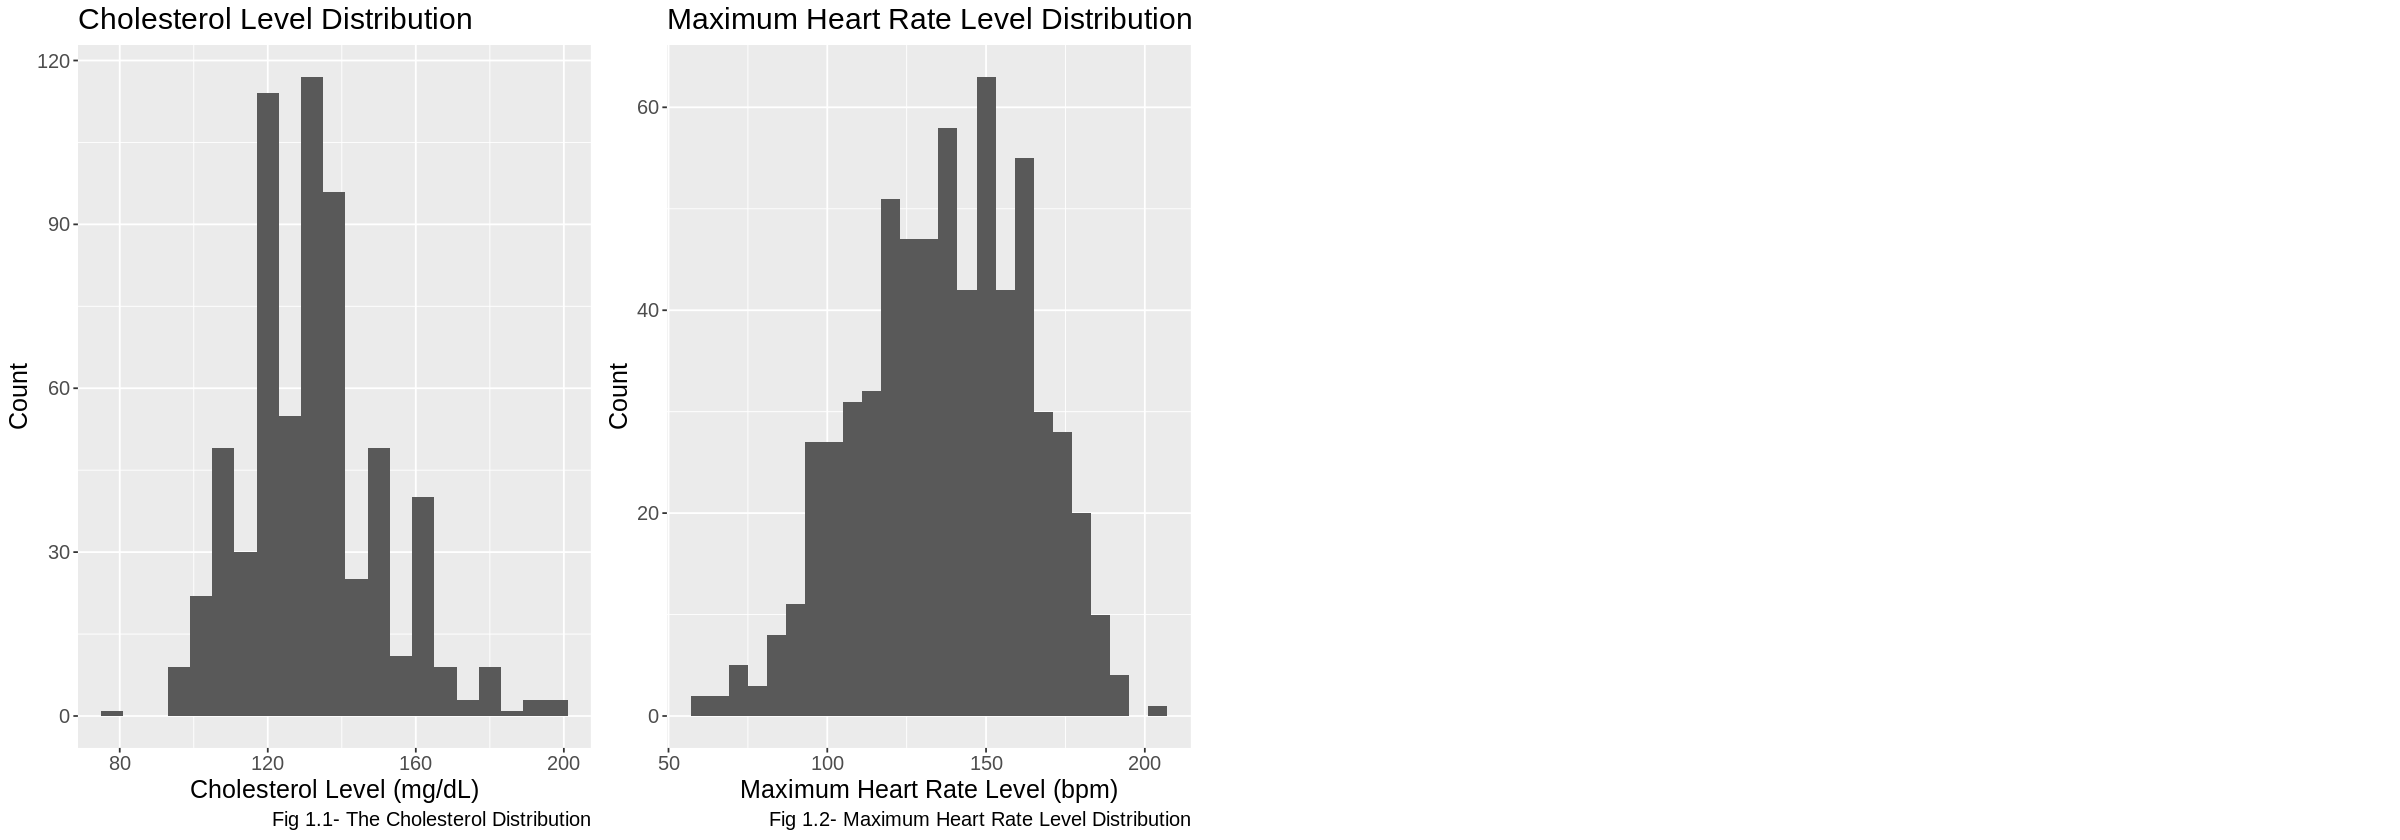

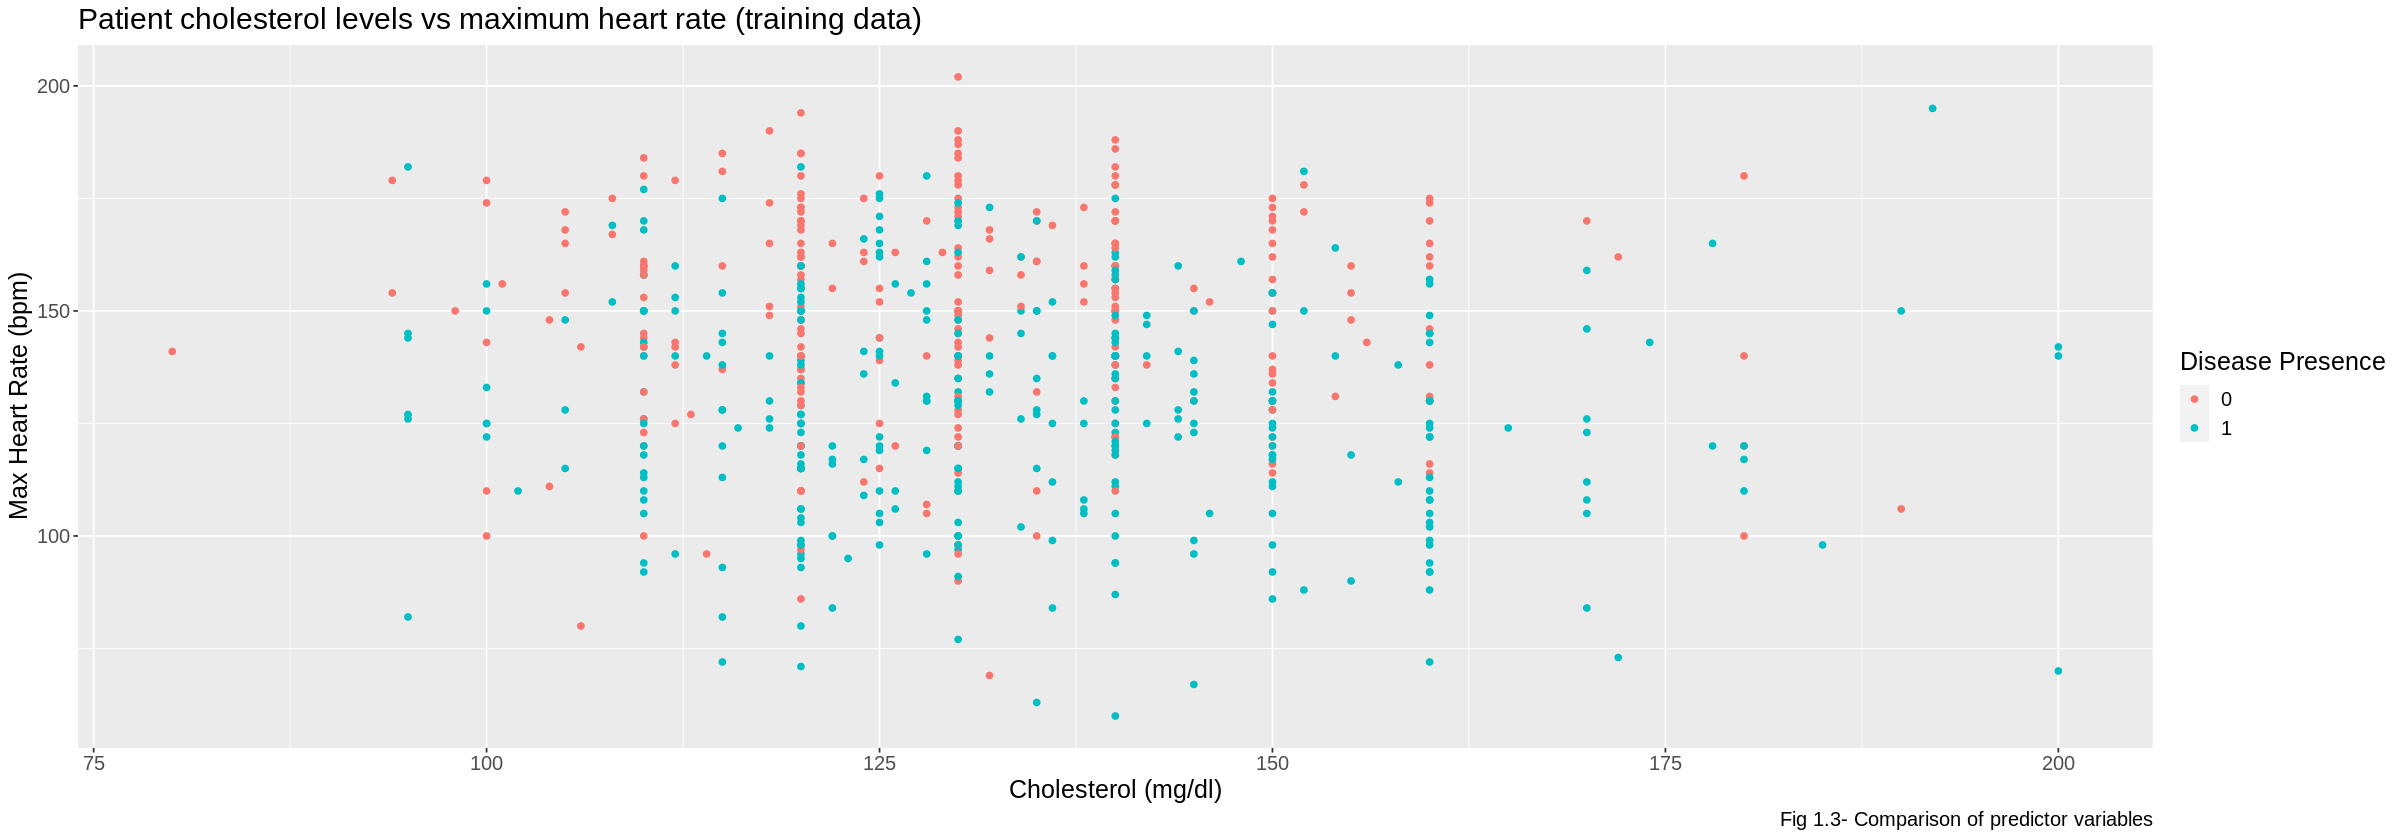

In [5]:
require(gridExtra)
options(repr.plot.height = 7, repr.plot.width = 20)
cholesterol_histogram <- ggplot(heart_train, aes(x = cholesterol)) +
    geom_histogram(binwidth = 6) +
    xlab("Cholesterol Level (mg/dL)") +
    ylab("Count") +
    labs(caption="Fig 1.1- The Cholesterol Distribution")+
    ggtitle("Cholesterol Level Distribution") +
    theme(text = element_text(size = 15))
max_hr_histogram <- ggplot(heart_train, aes(x = max_hr)) +
    geom_histogram(binwidth = 6) +
    xlab("Maximum Heart Rate Level (bpm)") +
    ylab("Count") +
    labs(caption="Fig 1.2- Maximum Heart Rate Level Distribution")+
    ggtitle("Maximum Heart Rate Level Distribution") +
    theme(text = element_text(size = 15))

grid.arrange(cholesterol_histogram, max_hr_histogram, ncol = 4)

# plot max heart rate vs cholesterol from training data
heart_plot <- ggplot(heart_train, aes(x = cholesterol, y = max_hr, color = disease_presence)) +
    geom_point() +
    labs(color = "Disease Presence", x = "Cholesterol (mg/dl)", y = "Max Heart Rate (bpm)",
            caption="Fig 1.3- Comparison of predictor variables") +
    theme(text = element_text(size = 12)) +
    ggtitle("Patient cholesterol levels vs maximum heart rate (training data)") +
    theme(text = element_text(size = 15))

heart_plot

This scatterplot of cholesterol vs max heart rate for our training data shows that most points with disease presence 1 have a higher cholesterol with a lower max heart rate, whereas most points with disease presence 0 have a higher max heart rate with lower cholesterol, although there are many points that do not fit this observation which may reduce the accuracy of our knn model in our later analysis.

## Data Analysis

To begin, we will create a recipe that uses all the predictors in the training set (age, resting blood pressure, and cholesterol), and scale and center the variables so we can be sure that they are on a comparable magnitude. We will then create a model specification with tuning on the number of neighbors. We will then perform a 5-fold cross-validation on the training set.

In [6]:
# create recipe with our two predictor variables specified
heart_recipe <- recipe(disease_presence ~ cholesterol + max_hr, data = heart_train) %>%
                # scale and center our variables
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# create knn model specification using rectangular distances for the nearest neighbors weight function
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# create cross validation object specifying the training data and that we will be using 5 fold cross validation (v = 5)
# to predict the strata which is disease presence.
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease_presence)

We will then create a workflow analysis with our recipe and model specification and in order to have a comprehensive analysis of the best K-value, we will have it try values of K from 1 to 80, incrementing by 2. We will then collect the metrics from this model to plot later.

In [7]:
# create tibble of neighbors from 1 to 100 to try
k_vals <- tibble(neighbors = seq(from = 1, to = 80, by = 2))

# create workflow
heart_fit <- workflow() %>%
            add_recipe(heart_recipe) %>%
            add_model(knn_spec) %>%
            # perform cross validation
            tune_grid(resamples = heart_vfold, grid = k_vals) %>%
            # collect metrics for analysis
            collect_metrics()

We will now plot the K-value against the accuracy it yields, to visualize which value of K yields the highest accuracy with the training data.

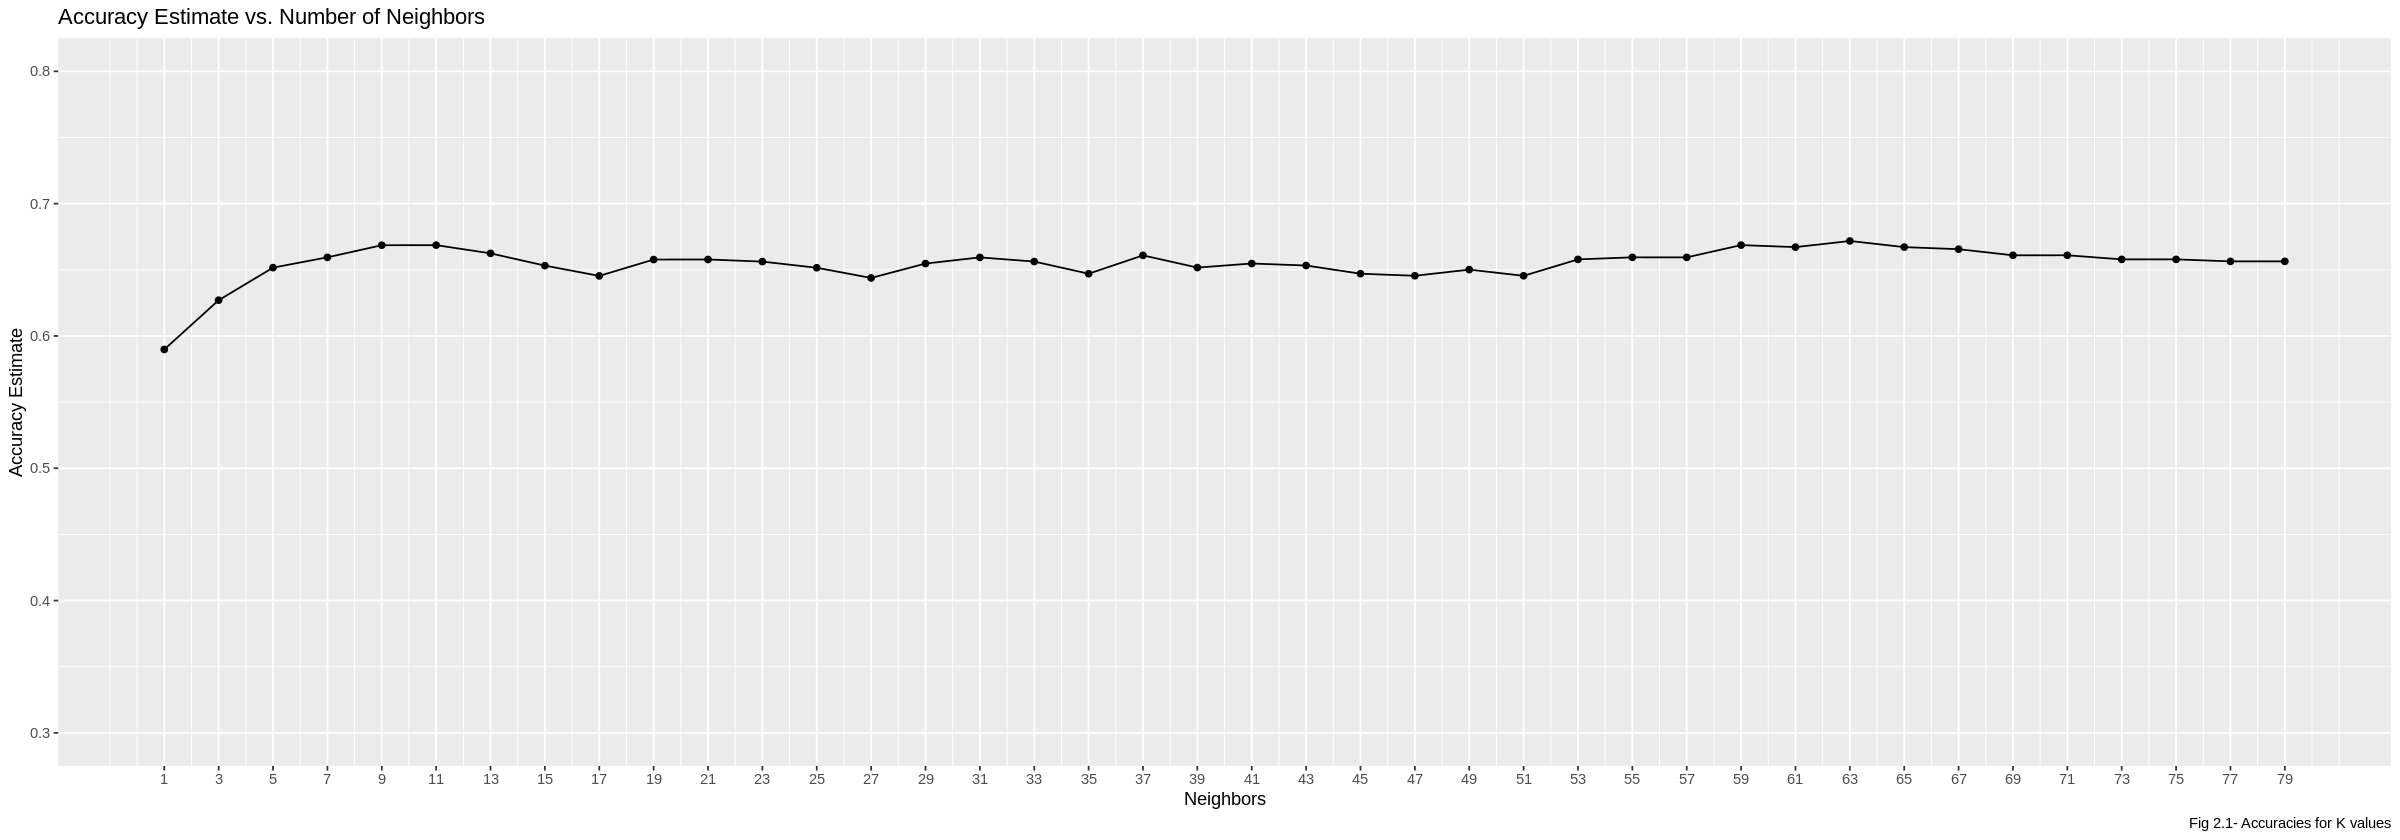

In [8]:
accuracies <- heart_fit %>% 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", caption="Fig 2.1- Accuracies for K values") +
    ggtitle("Accuracy Estimate vs. Number of Neighbors") +
    scale_x_continuous(breaks = seq(1, 80, by = 2)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.3, 0.8)) # adjusting the y-axis

cross_val_plot

Looking at the graph, it is hard to visually determine which k value gives the highest accuracy, however it appears to be either a value in the range of 59-65 or 9-13. We will use R to find the exact K value that provides the highest accuracy from our cross validation. Next, we use the k-value that gives the maximum accuracy to fit the best model and use this model to predict the disease presence of the testing data.

In [9]:
# get the k value that gives the highest accuracy
best_k <- accuracies %>% 
    # arrange by mean in descending order (this is the column with the accuracy values)
    arrange(desc(mean)) %>%
    # keep only the first row (highest accuracy)
    slice(1) %>% 
    # select the neighbors column and pull the neighbors value,
    # this is the k value that gives the best accuracy on predicting the training data
    select(neighbors) %>% 
    pull()

# create the new knn spec with the best k value
knn_spec_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# create the new model with the new best spec model
heart_fit_max <- workflow() %>% 
    add_recipe(heart_recipe) %>%
    add_model(knn_spec_best) %>%
    fit(data = heart_train)

# predict the disease presence of observations in the testing set
heart_predictions <- predict(heart_fit_max, heart_test) %>%
    bind_cols(heart_test) 
heart_predictions

.pred_class,cholesterol,max_hr,disease_presence
<fct>,<dbl>,<dbl>,<fct>
0,120,178,0
0,130,147,1
1,130,142,1
⋮,⋮,⋮,⋮
1,140,122,1
1,130,140,1
1,155,112,1


Now, we will compare the predictions to the true values and determine the models accuracy when predicting the disease presence of the testing data.

In [10]:
# collect metrics from the predictions using the metrics function
heart_metrics <- heart_predictions %>%
    metrics(truth = disease_presence, estimate = .pred_class) %>% 
    # filter for the accuracy metric
    filter(.metric == 'accuracy')
heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7196262


From the table, the accuracy of the model on the testing set is about 71.96 percent, slighlty higher than the observed accuracy of the training data which appears to be around 67% from the table. 

Next, we make a confusion matrix to summarize the results of the classification predictions and see how it misclassifies observations.

In [11]:
heart_conf_mat <- heart_predictions %>%
    conf_mat(truth = disease_presence, estimate = .pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 63 26
         1 34 91

From this table, we see that our model predicts the correct class 154 times out of 214 testing observations, with it correctly predicting no heart disease (disease_presence of 0) 63/97 times and correctly predicting the presence of heart disease (disease_presence of 1) 91/117 times. This means it predicts heart disease presence correctly around 78 percent of the time and the lack of heart disease correctly 65 percent of the time. 

### Graphing results

Using code from dsci 100 tutorial activity 6, we graph the patients max heart rate vs cholesterol levels with points colored by their class, and overlay what the model predicts at each point (shaded colors).

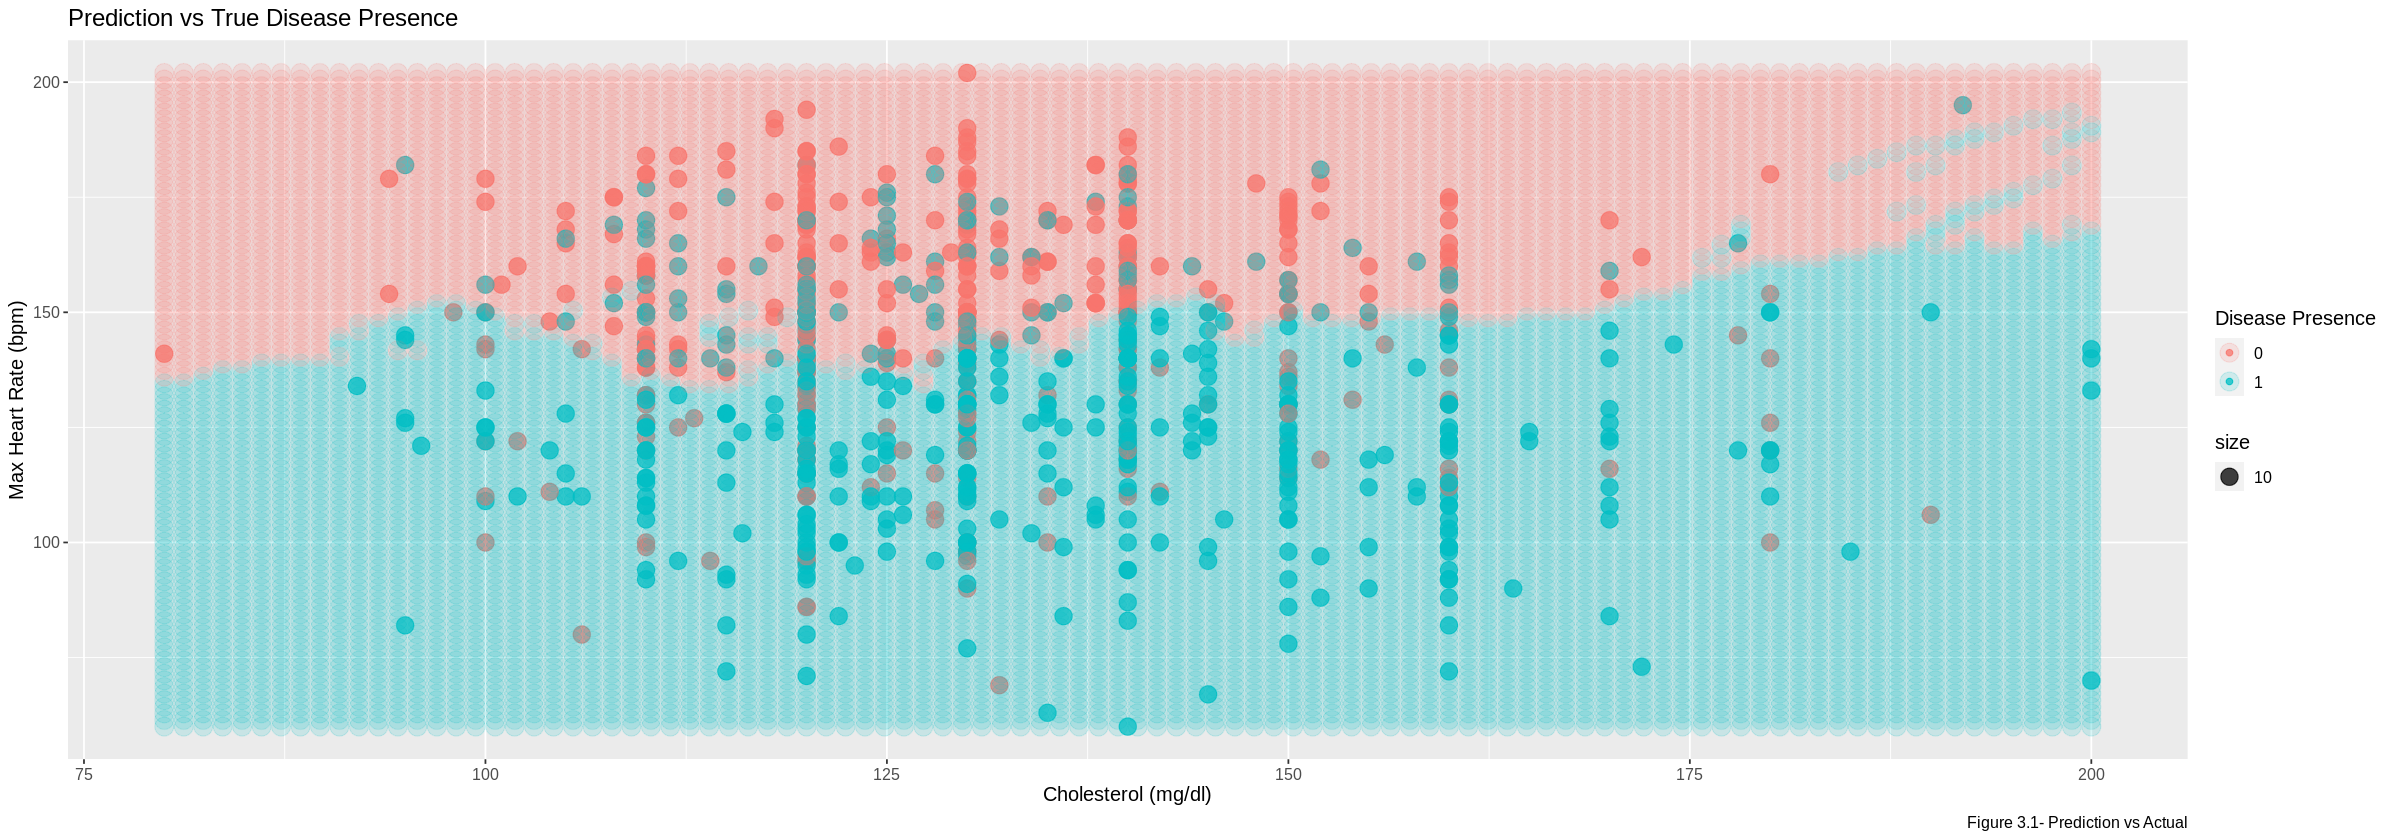

In [12]:
are_grid <- seq(min(heart_data$cholesterol, na.rm = TRUE), 
                max(heart_data$cholesterol, na.rm = TRUE), 
                length.out = 100)
smo_grid <- seq(min(heart_data$max_hr, na.rm = TRUE), 
                max(heart_data$max_hr, na.rm = TRUE), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(cholesterol = are_grid, 
                                max_hr = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit_max, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <- ggplot() +
    geom_point(data = heart_data, 
    mapping = aes(x = cholesterol, 
                  y = max_hr,
                  color = disease_presence,
                  size = 10), 
               alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = cholesterol, 
                                                      y = max_hr, 
                                                      color = Class), 
               alpha = 0.15, size = 5) +
    labs(color = "Disease Presence", x = "Cholesterol (mg/dl)", y = "Max Heart Rate (bpm)",
        caption="Figure 3.1- Prediction vs Actual") +
    theme(text = element_text(size = 12)) +
    ggtitle("Prediction vs True Disease Presence")

wkflw_plot

The graph shows that although there is a clear divide between where the model predicts a class of 0 or 1, there are many data points that are predicted incorrectly, as seen by the red data points in the blue shaded area and the blue data points in the red shaded area. 

## Expected outcomes and significance:

From figure 3.1, we can see that our classifier found that Heart Rate is a primary determinant of whether or not a patient has heart disease. More specifically, a lower heart rate generally corresponds to the presence of heart disease, while a higher maximum heart rate generally means the absence of heart disease. Moreover, the split between the sections of the graph is very horizontal, there is almost no vertical split, meaning that the classifier does not consider cholesterol levels to be a primary factor in detecting heart disease. However, when looking at the location of the data points, it seems that there are significantly more blue points (disease presence of 1) compared to red points (disease presence of 0) near the right side of the graph, whereas at the left side of the graph, there appears to be a comparable number of blue and red points. This could mean that higher cholesterol levels in a patient indicate that the patient is more likely to have heart disease, however, our classifier only shows a slight increase in the positive heart disease diagnosis’. This could also be attributed to a lack of data in the higher ranges of cholesterol levels, which limits the model to the range of our data, and predictions on the outer edges of it will not be as accurate.

Based on general information about heart disease, we expected higher heart rate and higher cholesterol levels to correspond to a higher likelihood of heart disease. This is not what our classifier predicted, which could be due to a number of reasons. Firstly, the dataset used was quite small, consisting of only approximately 600 data points. This means that the classifier did not have very much data to be trained on, to be able to see exactly how the presence of heart disease depends on each of the variables, especially after splitting the dataset into a training and testing set. With a bigger dataset, the classifier might have been able to better identify how the presence of heart disease depends on the variables and it would have been more representative of the general case. The dataset also included quite a few errors, with some columns such as cholesterol and blood pressure reporting values of 0 in many rows, values that are not physically possible. Although we filtered these obviously invalid data points in our exploratory analysis, the presence of this bad data could indicate that some of the other data was also of poor quality, leading to this deviation from our expectations. Additionally, this outcome could show that the presence of heart disease is more heavily dependent on different variables that were not included in the dataset, such as behavioral attributes and eating habits that are hard to quantify.

## Impacts of Findings

From our findings we could predict the presence of heart disease correctly about 72% of the time. Using the confusion matrix we see that our model predicts the correct class 154 times out of 214 testing observations, with it correctly predicting no heart disease (disease_presence of 0) 63/97 times and correctly predicting the presence of heart disease (disease_presence of 1) 91/117 times. This means it predicts heart disease presence correctly around 78 percent of the time and the lack of heart disease correctly 65 percent of the time. Due to the relatively low accuracy of our model, our findings will not have much of an impact. Although our classifier does an okay job of predicting the presence of heart disease, the accuracy is not high enough for it to be useful. It is important to have a high accuracy for predictions, especially when it comes to anything in the medical field. A potential misdiagnosis is dangerous, especially if it is predicted that someone does not have heart disease when they do. This can lead to people not receiving the treatment they need, and causing fatal issues later. Therefore, it is important that if a classifier is going to be used to predict the presence of heart disease, it needs to have a very high accuracy, somewhere in the range of 95% or greater, due to the dangerous consequences of leaving heart disease untreated.

The results of this investigation suggest that further investigation is needed into which factors impact the presence of heart disease the most. Since many behavioral traits were not included in the dataset due to the difficulty of quantifying things such as how healthy a patient's lifestyle is, many factors that may have a larger impact on heart disease went unassessed in our model. These “intermediate risk factors” relate to a patient’s general lifestyle, including the amount of exercise a patient gets and their diet, as well as other factors such as the patient’s family history and any diseases they may have such as diabetes.  According to further research conducted by the National Center for Biotechnology Information, 80%-90% of patients that had heart disease had some form of intermediate risk factor, showing that these risk factors greatly affect the presence of heart disease. In addition, some other factors such as the patient’s living conditions, their socioeconomic status, and the environment in which they live (whether they live in an unfavorable climate or live in a very unhygienic location) can also greatly affect the risk and presence of heart disease, but variables such as these were not able to be incorporated into our analysis due to the their unquantifiable nature, and the limited number of variables included in our dataset. This leads to further questions as to how to quantify and evaluate some of these categorical  variables to gather larger datasets that take these behavioural and social traits into account. If we want to help diagnose and treat heart disease before it progresses, further analysis and data collection  is needed to develop and assess the accuracy of new models with different choices of predictor variables. Thus, as a result of our models relatively low accuracy, we cannot recommend it as a good  model to predict such an important diagnoses of the presence of heart disease in patients. With further research, resources and data collection, we are confident future models can improve on ours and achieve greater accuracies to predict the presence of heart disease early on, and to save lives. 


### References:

Government of Canada. (2015, April 9). Chronic Disease Risk Factors. Canada.ca. https://www.canada.ca/en/public-health/services/chronic-diseases/chronic-disease-risk-factors.html 

Helfand, M. (2009, October). Screening for Intermediate Risk Factors for Coronary Heart Disease. National Center for Biotechnology https://www.ncbi.nlm.nih.gov/books/NBK35210/ 

UCI machine learning repository: Heart disease data set. (n.d.). Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

World Health Organization. (2019, June 11). Cardiovascular diseases. World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1

World Health Organization. (2021, June 11). Cardiovascular diseases (cvds). World Health Organization. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)#:~:text=The%20most%20important%20behavioural%20risk,lipids%2C%20and%20overweight%20and%20obesity
